# Lab3 – Data Engineering & EDA with Python, SQL, and Pandas

**Coursework goal:** practice hands-on data engineering by generating synthetic employee data, storing it in a free cloud Postgres database (Neon), loading it with Python, and performing EDA + visualizations.

> ✅ **Important:** You must create a free Neon Postgres database and paste your connection details in the **Environment Variables** cell below.  
> This notebook is written so you can run it end-to-end after you set those variables.


## 0. Setup

This notebook uses:
- **Neon Postgres** (cloud database)
- **psycopg2** for connecting + inserting
- **Pandas** for data wrangling
- **Faker** for synthetic records
- **Matplotlib** for visualizations
- **scikit-learn** for scaling

Run the install cell once (or ensure these are already installed in your environment).


In [13]:
# If needed, install dependencies (uncomment if running in a fresh environment)
# !pip install pandas psycopg2-binary faker matplotlib scikit-learn python-dotenv

import os
import random
from datetime import date

import pandas as pd
import numpy as np

import psycopg2
from psycopg2.extras import execute_values

from faker import Faker

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## 1. Data Collection & Database Connection

### 1.1 Create a free Neon database
1. Go to Neon.tech → create a free project
2. Copy your connection info (host, database, user, password, port)
3. Set environment variables below (recommended), or paste them directly.

**Why environment variables?**  
It prevents accidentally committing credentials into GitHub.


In [14]:
NEON_HOST = "ep-wispy-mountain-aijldqct-pooler.c-4.us-east-1.aws.neon.tech"
NEON_DB = "workshop"
NEON_USER = "neondb_owner"
NEON_PASSWORD = "npg_c74uqSvUsyPR"
NEON_PORT = 5432

CONN_INFO = dict(
    host=NEON_HOST,
    dbname=NEON_DB,
    user=NEON_USER,
    password=NEON_PASSWORD,
    port=NEON_PORT,
    sslmode="require",  # Neon typically requires SSL
)

CONN_INFO


{'host': 'ep-wispy-mountain-aijldqct-pooler.c-4.us-east-1.aws.neon.tech',
 'dbname': 'workshop',
 'user': 'neondb_owner',
 'password': 'npg_c74uqSvUsyPR',
 'port': 5432,
 'sslmode': 'require'}

### 1.2 Connect to Postgres (Neon)

We connect using `psycopg2`, then use SQL to create the required table(s).


In [15]:
def get_conn():
    return psycopg2.connect(**CONN_INFO)

# quick connection test
with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT NOW();")
        print("Connected. Server time:", cur.fetchone()[0])

Connected. Server time: 2026-02-06 03:57:51.633077+00:00


### 1.3 Create tables

Required table: **employees**

We also create a **departments** table to support the *advanced visualization challenge* (join + more complex dataset).


In [16]:
def create_tables():
    EMPLOYEES_DDL = '''
    CREATE TABLE IF NOT EXISTS employees (
        employee_id INTEGER PRIMARY KEY,
        name TEXT NOT NULL,
        position TEXT NOT NULL,
        start_date DATE NOT NULL,
        salary INTEGER NOT NULL CHECK (salary BETWEEN 60000 AND 200000)
    );
    '''

    # second table for part 3
    DEPARTMENTS_DDL = '''
    CREATE TABLE IF NOT EXISTS departments (
        department_id SERIAL PRIMARY KEY,
        department_name TEXT NOT NULL,
        location TEXT NOT NULL,
        annual_budget INTEGER NOT NULL CHECK (annual_budget BETWEEN 200000 AND 5000000)
    );
    '''

    # relationship table (employee belongs to a department)
    EMP_DEPT_DDL = '''
    CREATE TABLE IF NOT EXISTS employee_departments (
        employee_id INTEGER PRIMARY KEY REFERENCES employees(employee_id) ON DELETE CASCADE,
        department_id INTEGER NOT NULL REFERENCES departments(department_id) ON DELETE CASCADE
    );
    '''

    with get_conn() as conn:
        with conn.cursor() as cur:
            cur.execute(EMPLOYEES_DDL)
            cur.execute(DEPARTMENTS_DDL)
            cur.execute(EMP_DEPT_DDL)
        conn.commit()

    print("Tables ensured: employees, departments, employee_departments")


### 1.4 Generate & populate synthetic records (≥ 50)

We generate **at least 50 employees** using Faker:
- IT-related positions
- start_date between 2015 and 2024
- salary between 60k and 200k

Then we insert into Neon Postgres.


In [17]:
fake = Faker()

POSITIONS = [
    "Data Engineer",
    "Data Analyst",
    "ML Engineer",
    "Cloud Engineer",
    "DevOps Engineer",
    "Backend Developer",
    "Full Stack Developer",
    "Database Administrator",
    "Cybersecurity Analyst",
    "QA Automation Engineer",
]

DEPT_SEED = [
    ("Data Platform", "Toronto, ON"),
    ("Cloud Infrastructure", "Waterloo, ON"),
    ("Security", "Ottawa, ON"),
    ("Product Engineering", "Mississauga, ON"),
    ("Analytics", "Montreal, QC"),
]

def random_date_2015_2024():
    # Faker date_between with explicit bounds
    return fake.date_between(start_date="2015-01-01", end_date="2024-12-31")

def gen_employees(n=80, start_id=1001):
    records = []
    for i in range(n):
        emp_id = start_id + i
        name = fake.name()
        position = random.choice(POSITIONS)
        start_date = random_date_2015_2024()
        salary = random.randint(60000, 200000)
        records.append((emp_id, name, position, start_date, salary))
    return records

def gen_departments():
    rows = []
    for dept_name, loc in DEPT_SEED:
        budget = random.randint(300000, 4000000)
        rows.append((dept_name, loc, budget))
    return rows

# employees_rows = gen_employees(n=80, start_id=1001)  # >= 50
# departments_rows = gen_departments()

# len(employees_rows), len(departments_rows), employees_rows[0]


def count_tables(cur):
    tables = ["employees", "departments", "employee_departments"]
    counts = {}
    for table in tables:
        cur.execute(f"SELECT COUNT(*) FROM {table};")
        counts[table] = cur.fetchone()[0]
        print(f"Table {table} has {counts[table]} rows.")
    return counts

#### Insert into database

To make re-runs easy, we:
- **TRUNCATE** (clear) tables first
- Insert fresh synthetic data


In [18]:
with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT COUNT(*) FROM employees;")
        emp_count = cur.fetchone()[0]

        if emp_count == 0:
            print("Employees table empty → inserting data...")

            # Clear all tables first
            cur.execute("""
            TRUNCATE TABLE employee_departments, employees, departments
            RESTART IDENTITY;
            """)

            employees_rows = gen_employees(n=80, start_id=1001)  # >= 50
            departments_rows = gen_departments()

            print(len(employees_rows), len(departments_rows), employees_rows[0])

            # Insert departments
            execute_values(
                cur,
                "INSERT INTO departments (department_name, location, annual_budget) VALUES %s",
                departments_rows,
            )

            # Insert employees
            execute_values(
                cur,
                "INSERT INTO employees (employee_id, name, position, start_date, salary) VALUES %s",
                employees_rows,
            )

            # Assign each employee to a department (random mapping)
            cur.execute("SELECT department_id FROM departments;")
            dept_ids = [r[0] for r in cur.fetchall()]
            emp_dept_rows = [(emp_id, random.choice(dept_ids)) for (emp_id, *_rest) in employees_rows]

            execute_values(
                cur,
                "INSERT INTO employee_departments (employee_id, department_id) VALUES %s",
                emp_dept_rows,
            )
            conn.commit()
            print("Inserted:", len(employees_rows), "employees,", len(departments_rows), "departments, and employee_department mappings.")
        else:
            print("Skipping insertion.")
            count_tables(cur)

Skipping insertion.
Table employees has 80 rows.
Table departments has 5 rows.
Table employee_departments has 80 rows.


### 1.5 Query and load data into a Pandas DataFrame

We query the entire employee table and display `df.head()` as required.


In [19]:

with get_conn() as conn:
    df_emp = pd.read_sql("SELECT * FROM employees ORDER BY employee_id;", conn)

df_emp.head()


/var/folders/76/5mf0k27s4bbgd15c92tvkzpc0000gp/T/ipykernel_27299/4237117105.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_emp = pd.read_sql("SELECT * FROM employees ORDER BY employee_id;", conn)


,employee_id,name,position,start_date,salary
0,1001,Dylan Fuller,Data Analyst,2023-07-19,87130
1,1002,Theresa Hoffman,Backend Developer,2020-12-25,61016
2,1003,Tommy Johnson,Database Administrator,2021-08-08,124171
3,1004,Mr. Kenneth Hull,Data Engineer,2022-08-12,169672
4,1005,Benjamin Brown,Data Engineer,2018-03-19,186488


## 2. Exploratory Data Analysis (EDA)

In this section we demonstrate:
- **Descriptive statistics**: `.info()`, `.describe()`
- **Missing values**: `.isnull().sum()`
- Basic sanity checks (salary range, date range)


In [20]:
df_emp.info()


<class 'pandas.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   employee_id  80 non-null     int64 
 1   name         80 non-null     str   
 2   position     80 non-null     str   
 3   start_date   80 non-null     object
 4   salary       80 non-null     int64 
dtypes: int64(2), object(1), str(2)
memory usage: 3.3+ KB


In [21]:
df_emp.describe(include="all")


,employee_id,name,position,start_date,salary
count,80.0000,80,80,80,80.000000
unique,NaN,80,10,79,NaN
top,NaN,Dylan Fuller,Data Analyst,2022-09-10,NaN
freq,NaN,1,11,2,NaN
mean,1040.5000,NaN,NaN,NaN,125742.125000
std,23.2379,NaN,NaN,NaN,42138.842797
min,1001.0000,NaN,NaN,NaN,60791.000000
25%,1020.7500,NaN,NaN,NaN,87589.750000
50%,1040.5000,NaN,NaN,NaN,122883.000000
75%,1060.2500,NaN,NaN,NaN,162076.500000


In [22]:
df_emp.isnull().sum()


employee_id    0
name           0
position       0
start_date     0
salary         0
dtype: int64

## 3. Data Cleaning

Because the data is synthetic, we expect no missing values, but we still **check and enforce**:
- salary within **[60k, 200k]**
- start_date between **2015-01-01** and **2024-12-31**
- normalize position names (trim spaces, consistent casing)


In [23]:
# Ensure correct dtypes
df_emp["start_date"] = pd.to_datetime(df_emp["start_date"])

# Normalize positions
df_emp["position"] = df_emp["position"].astype(str).str.strip()

# Sanity checks
salary_outside = df_emp[(df_emp["salary"] < 60000) | (df_emp["salary"] > 200000)]
date_outside = df_emp[(df_emp["start_date"] < "2015-01-01") | (df_emp["start_date"] > "2024-12-31")]

salary_outside.shape, date_outside.shape


((0, 5), (0, 5))

## 4. Data Transformation & Feature Engineering

We add:
- `start_year`: extracted from start_date
- `years_of_service`: years from start_date to a reference date (today)

These are useful for grouping, trends, and tenure-based analysis.


In [24]:
today = pd.Timestamp(date.today())

df_emp["start_year"] = df_emp["start_date"].dt.year
df_emp["years_of_service"] = ((today - df_emp["start_date"]).dt.days / 365.25).round(2)

df_emp[["employee_id", "position", "start_date", "start_year", "years_of_service", "salary"]].head()


,employee_id,position,start_date,start_year,years_of_service,salary
0,1001,Data Analyst,2023-07-19,2023,2.55,87130
1,1002,Backend Developer,2020-12-25,2020,5.11,61016
2,1003,Database Administrator,2021-08-08,2021,4.50,124171
3,1004,Data Engineer,2022-08-12,2022,3.49,169672
4,1005,Data Engineer,2018-03-19,2018,7.89,186488


## 5. Scaling

We apply scaling to numeric columns to prepare data for modeling and to compare features on a similar scale.

Here we scale:
- `salary`
- `years_of_service`

We demonstrate **MinMaxScaler** (0 to 1). (StandardScaler is also valid.)


In [25]:
scaler = MinMaxScaler()
df_scaled = df_emp.copy()

df_scaled[["salary_scaled", "years_scaled"]] = scaler.fit_transform(df_emp[["salary", "years_of_service"]])

df_scaled[["salary", "salary_scaled", "years_of_service", "years_scaled"]].head()


,salary,salary_scaled,years_of_service,years_scaled
0,87130,0.190587,2.55,0.145582
1,61016,0.001628,5.11,0.402610
2,124171,0.458614,4.50,0.341365
3,169672,0.787857,3.49,0.239960
4,186488,0.909536,7.89,0.681727


## 6. Visualization 1 (Standard): Average Salary by Position and Start Year

**Goal:** grouped bar chart showing the **average salary** by:
- `position`
- `start_year`

This matches the class-style visualization requirement.


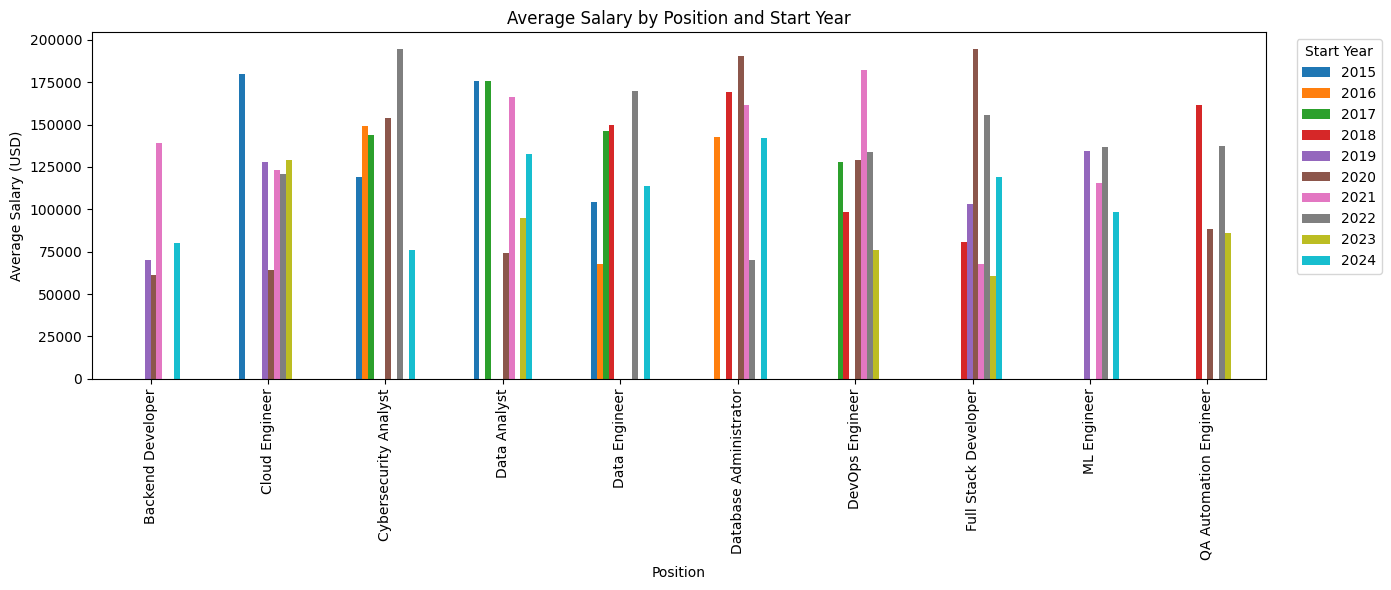

In [26]:
# Pivot for grouped bar chart
pivot = (
    df_emp
    .groupby(["position", "start_year"])["salary"]
    .mean()
    .reset_index()
    .pivot(index="position", columns="start_year", values="salary")
    .fillna(0)
)

ax = pivot.plot(kind="bar", figsize=(14, 6))
ax.set_title("Average Salary by Position and Start Year")
ax.set_xlabel("Position")
ax.set_ylabel("Average Salary (USD)")
ax.legend(title="Start Year", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


### Findings (Visualization 1)

Write 3–5 bullets **in your own words** after you run the plot. Example structure:
- Which positions tend to have higher averages?
- Are there any years with unusually high/low averages (could be random synthetic variation)?
- Any noticeable changes over time?

*(Replace the placeholders below with your observations.)*

- Observation 1: …
- Observation 2: …
- Observation 3: …


## 7. Visualization 2 (Advanced): Join with Departments + Heatmap

### 7.1 Build a more complex dataset (SQL join)
We join:
- employees
- employee_departments
- departments

Then visualize **average salary** by:
- department_name
- position

We use a **heatmap** (matplotlib `imshow`) to satisfy the advanced visualization requirement.


In [27]:
with get_conn() as conn:
    df_joined = pd.read_sql(
        '''
        SELECT 
            e.employee_id,
            e.name,
            e.position,
            e.start_date,
            e.salary,
            d.department_name,
            d.location,
            d.annual_budget
        FROM employees e
        JOIN employee_departments ed ON e.employee_id = ed.employee_id
        JOIN departments d ON ed.department_id = d.department_id
        ORDER BY e.employee_id;
        ''',
        conn
    )

df_joined["start_date"] = pd.to_datetime(df_joined["start_date"])
df_joined["start_year"] = df_joined["start_date"].dt.year
df_joined.head()


/var/folders/76/5mf0k27s4bbgd15c92tvkzpc0000gp/T/ipykernel_27299/2360013794.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_joined = pd.read_sql(


,employee_id,name,position,start_date,salary,department_name,location,annual_budget,start_year
0,1001,Dylan Fuller,Data Analyst,2023-07-19,87130,Cloud Infrastructure,"Waterloo, ON",2124400,2023
1,1002,Theresa Hoffman,Backend Developer,2020-12-25,61016,Security,"Ottawa, ON",2900575,2020
2,1003,Tommy Johnson,Database Administrator,2021-08-08,124171,Cloud Infrastructure,"Waterloo, ON",2124400,2021
3,1004,Mr. Kenneth Hull,Data Engineer,2022-08-12,169672,Analytics,"Montreal, QC",1976570,2022
4,1005,Benjamin Brown,Data Engineer,2018-03-19,186488,Analytics,"Montreal, QC",1976570,2018


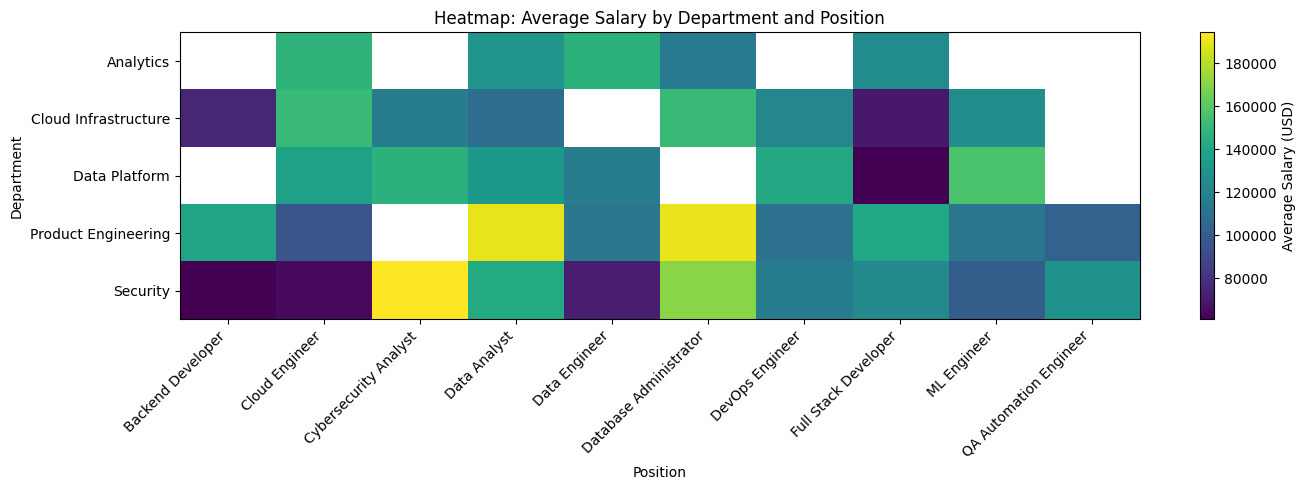

In [28]:

# Create a table of avg salary by department and position
heat = (
    df_joined
    .groupby(["department_name", "position"])["salary"]
    .mean()
    .reset_index()
    .pivot(index="department_name", columns="position", values="salary")
)

# Heatmap with imshow (no seaborn)
fig, ax = plt.subplots(figsize=(14, 5))
im = ax.imshow(heat.values, aspect="auto")

ax.set_title("Heatmap: Average Salary by Department and Position")
ax.set_xlabel("Position")
ax.set_ylabel("Department")

ax.set_xticks(np.arange(heat.shape[1]))
ax.set_xticklabels(heat.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(heat.shape[0]))
ax.set_yticklabels(heat.index)

# Add a colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Average Salary (USD)")

plt.tight_layout()
plt.show()


### Findings (Visualization 2)

Write 3–5 bullets **in your own words** after you run the heatmap. Example structure:
- Which department + position combinations have the highest averages?
- Is one department consistently higher across roles?
- Any outliers that might come from random assignment?

*(Replace the placeholders below with your observations.)*

- Observation 1: …
- Observation 2: …
- Observation 3: …


## 8. Insights & Conclusions

Summarize what you learned:
- connecting Python ↔ cloud Postgres
- generating + inserting data
- cleaning / transformation / feature engineering
- scaling
- building visualizations and extracting insights

**Example outline:**
- What worked smoothly?
- What was tricky?
- What you would improve if this were real HR data?
